In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import friedmanchisquare, rankdata
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


In [5]:
# read data
data = pd.read_csv("alzheimers_disease_data.csv")
data.shape
data.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

In [7]:
class_counts = data.iloc[:, -1].value_counts(normalize=True) * 100
print("Original Class Distribution:\n", class_counts)

# Splitting features and target variable
X = data.iloc[:, :-1]  # Features
y = data.iloc[:, -1]   # Target

# Separate majority and minority classes
majority_class = data[y == 0]  # Non-Alzheimer's (64.6%)
minority_class = data[y == 1]  # Alzheimer's (35.4%)

# Undersample the majority class to match the minority class size
majority_downsampled = resample(majority_class, 
                                replace=False,  # Without replacement
                                n_samples=len(minority_class),  # Match minority class size
                                random_state=42)

# Combine the downsampled majority class with the original minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
new_class_counts = balanced_data.iloc[:, -1].value_counts(normalize=True) * 100
print("Balanced Class Distribution:\n", new_class_counts)

Original Class Distribution:
 Diagnosis
0    64.634714
1    35.365286
Name: proportion, dtype: float64
Balanced Class Distribution:
 Diagnosis
0    50.0
1    50.0
Name: proportion, dtype: float64


In [9]:
# Step 1: Select the nominal categorical features
nominal_features = ['Ethnicity', 'EducationLevel']

# Step 2: Initialize One-Hot Encoder without dropping any category
ohe = OneHotEncoder(drop=None, sparse_output=False)  # Keep all categories

# Step 3: Fit and transform the categorical features
encoded_features = ohe.fit_transform(balanced_data[nominal_features])

# Step 4: Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(nominal_features))

# Step 5: Drop the original categorical columns and merge encoded features
data = balanced_data.drop(columns=nominal_features).reset_index(drop=True)  # Drop original categorical columns
data = pd.concat([data, encoded_df], axis=1)  # Merge encoded data

# Step 6: Verify the transformed data
print("Updated Dataset After One-Hot Encoding:")
data.head()

Updated Dataset After One-Hot Encoding:


,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,Forgetfulness,Diagnosis,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,EducationLevel_0,EducationLevel_1,EducationLevel_2,EducationLevel_3
0,80,1,16.834968,0,19.053565,4.352272,3.432055,7.361459,0,0,...,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,88,1,35.353244,1,0.768943,8.883326,4.085773,7.450835,0,0,...,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,63,0,32.726550,0,16.971929,8.569751,8.744619,9.227229,0,0,...,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,75,1,38.668960,1,6.669039,7.328895,7.973275,9.966551,0,0,...,1,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,72,0,30.646711,0,4.452856,0.768016,4.978013,7.715735,0,1,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
selected_features = ['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems', 'SleepQuality', 'CholesterolHDL', 'CholesterolLDL', 'BMI', 'CholesterolTriglycerides', 'Age', 'PhysicalActivity', 'DietQuality', 'DiastolicBP', 'Gender']

In [13]:
top_selected_features = ['FunctionalAssessment', 'ADL', 'MemoryComplaints', 'MMSE', 'BehavioralProblems']

In [15]:
# Correct filtering for Male and Female
male = data[data['Gender'] == 0]  # Assuming 0 represents Male
female = data[data['Gender'] == 1]  # Assuming 1 represents Female

X = data[selected_features]  
X_top = data[top_selected_features]  
y = data['Diagnosis']


# Split features and target for Males
X_male = male[selected_features]  
y_male = male['Diagnosis']

# Split features and target for Females
X_female = female[selected_features]  
y_female = female['Diagnosis']




In [17]:
male.shape

(763, 39)

In [19]:
female.shape

(757, 39)

In [21]:
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

scaler_top = StandardScaler()

# Fit on training data and transform both train and test separately
X_train_scaled_top = scaler_top.fit_transform(X_train_top)  
X_test_scaled_top = scaler_top.transform(X_test_top)  


# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()

# Fit on training data and transform both train and test separately
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

# Split Male Data
X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
    X_male, y_male, test_size=0.2, random_state=42
)

# Split Female Data
X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
    X_female, y_female, test_size=0.2, random_state=42
)

# Initialize StandardScaler
scaler_male = StandardScaler()
scaler_female = StandardScaler()

# Scale Male Data
X_male_train_scaled = scaler_male.fit_transform(X_male_train)
X_male_test_scaled = scaler_male.transform(X_male_test)

# Scale Female Data
X_female_train_scaled = scaler_female.fit_transform(X_female_train)
X_female_test_scaled = scaler_female.transform(X_female_test)

## 15

Accuracy: 0.9375

Classification Report:
               precision    recall  f1-score   support

           0      0.923     0.954     0.938       151
           1      0.953     0.922     0.937       153

    accuracy                          0.938       304
   macro avg      0.938     0.938     0.937       304
weighted avg      0.938     0.938     0.937       304


Confusion Matrix:
 [[144   7]
 [ 12 141]]


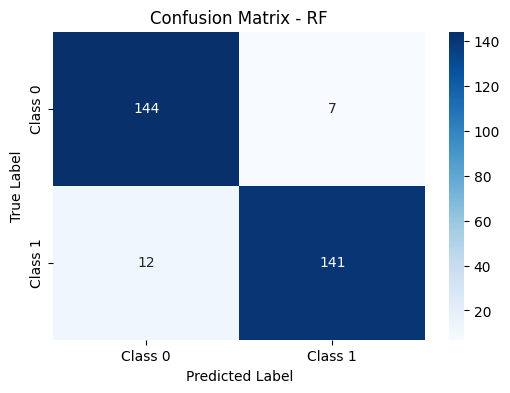

In [27]:
RF = RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  )  


RF.fit(X_train_scaled, y_train)

RF_y_pred = RF.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, RF_y_pred))
print("\nClassification Report:\n", classification_report(y_test, RF_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, RF_y_pred))

cm = confusion_matrix(y_test, RF_y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RF")
plt.show()

Accuracy: 0.9407894736842105

Classification Report:
               precision    recall  f1-score   support

           0      0.929     0.954     0.941       151
           1      0.953     0.928     0.940       153

    accuracy                          0.941       304
   macro avg      0.941     0.941     0.941       304
weighted avg      0.941     0.941     0.941       304


Confusion Matrix:
 [[144   7]
 [ 11 142]]


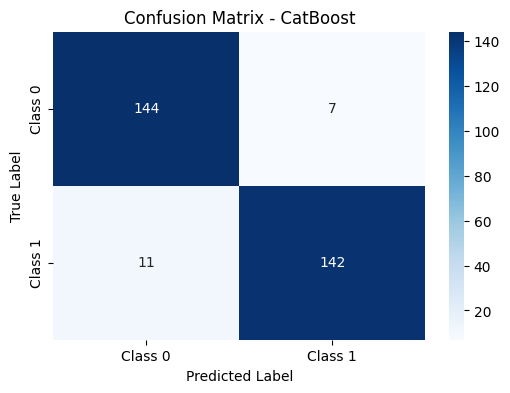

In [85]:
catboost = CatBoostClassifier(
    border_count=128, 
    depth=4, 
    iterations=500, 
    l2_leaf_reg=3, 
    learning_rate=0.01, 
    loss_function='Logloss', 
    random_seed=42,  
    verbose=0  
) 


catboost.fit(X_train_scaled, y_train)

catboost_y_pred = catboost.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, catboost_y_pred))
print("\nClassification Report:\n", classification_report(y_test, catboost_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, catboost_y_pred))

cm = confusion_matrix(y_test, catboost_y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CatBoost")
plt.show()

## Top 5

In [75]:
RF = RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  )  


RF.fit(X_train_scaled_top, y_train_top)

RF_y_pred = RF.predict(X_test_scaled_top)

print("Accuracy:", accuracy_score(y_test_top, RF_y_pred))
print("\nClassification Report:\n", classification_report(y_test_top, RF_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_top, RF_y_pred))


Accuracy: 0.9407894736842105

Classification Report:
               precision    recall  f1-score   support

           0      0.924     0.960     0.942       151
           1      0.959     0.922     0.940       153

    accuracy                          0.941       304
   macro avg      0.941     0.941     0.941       304
weighted avg      0.941     0.941     0.941       304


Confusion Matrix:
 [[145   6]
 [ 12 141]]


## male

In [77]:
RF = RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  )

RF.fit(X_male_train_scaled, y_male_train)

RF_y_pred = RF.predict(X_male_test_scaled)

print("Accuracy:", accuracy_score(y_male_test, RF_y_pred))
print("\nClassification Report:\n", classification_report(y_male_test, RF_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_male_test, RF_y_pred))


Accuracy: 0.8954248366013072

Classification Report:
               precision    recall  f1-score   support

           0      0.843     0.922     0.881        64
           1      0.940     0.876     0.907        89

    accuracy                          0.895       153
   macro avg      0.891     0.899     0.894       153
weighted avg      0.899     0.895     0.896       153


Confusion Matrix:
 [[59  5]
 [11 78]]


## Female

In [79]:
RF = RandomForestClassifier(
    bootstrap=False, 
    max_depth=None, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_estimators=200, 
    random_state=42  )

RF.fit(X_female_train_scaled, y_female_train)

RF_y_pred = RF.predict(X_female_test_scaled)

print("Accuracy:", accuracy_score(y_female_test, RF_y_pred))
print("\nClassification Report:\n", classification_report(y_female_test, RF_y_pred, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_female_test, RF_y_pred))


Accuracy: 0.9407894736842105

Classification Report:
               precision    recall  f1-score   support

           0      0.936     0.948     0.942        77
           1      0.946     0.933     0.940        75

    accuracy                          0.941       152
   macro avg      0.941     0.941     0.941       152
weighted avg      0.941     0.941     0.941       152


Confusion Matrix:
 [[73  4]
 [ 5 70]]
